# Model Training (Iterative Subset Runs)

This notebook trains a base code model using a **mixed dataset** containing:
- **FIM autocomplete** samples (`task=autocomplete_fim`)
- **comment/docstring → code** samples (`task=comment2code`)

In [1]:
# Imports
import sys
import json
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

import numpy as np
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import Trainer

from peft import LoraConfig, TaskType, get_peft_model

In [2]:
# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

print("Project root added to path:", project_root)

Project root added to path: /Users/tgdimas1/Projs/python/code_complete


In [3]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
)

In [4]:
# Import shared code modules
from src.config import MODELS_DIR, EVAL_DIR, ADAPTER_DIR, UNIFIED_DIR
from src.config import MODEL_NAME, MAX_LENGTH, SEED, NUM_ITERATIONS, SAMPLES_PER_ITERATION, EPOCHS_PER_ITERATION, BATCH_SIZE, VAL_MAX_SAMPLES
from src.config import LORA_TARGET_MODULES, LORA_R, LORA_ALPHA, LORA_DROPOUT
from src.data_processing import load_train_val_data, build_fim_text, build_c2c_prompt_completion, MixedDispatchCollator, Comment2CodeCollator, FimCollator
from src.evaluation import (
    evaluate_model_on_prompts,
    print_evaluation_summary,
    GENERIC_EVAL_PROMPTS,
    CDK_EVAL_PROMPTS
)

from src.training_utils import get_latest_checkpoint, save_iteration_indices, load_iteration_indices

In [5]:
print('torch:', torch.__version__)

torch: 2.9.1


In [6]:
# Device selection (CUDA > MPS > CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")


Using device: mps


## Configuration
Tune these for quick iteration first (small subsets), then scale up.

In [7]:
# Paths
for dir_path in [MODELS_DIR, ADAPTER_DIR, EVAL_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Model configuration
# Tip: start with 1–3B locally, then try bigger if you have RAM/VRAM
print(f"Using model: {MODEL_NAME}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Seed: {SEED}")

# Iterative training (subset runs)
print(f"Number of iterations: {NUM_ITERATIONS}")
print(f"Samples per iteration: {SAMPLES_PER_ITERATION}")

# Training
print(f"Epoch per iteration: {EPOCHS_PER_ITERATION}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Validation max samples: {VAL_MAX_SAMPLES}")

# Training hyperparameters
GRADIENT_ACCUMULATION_STEPS = 8
LEARNING_RATE = 2e-4
WARMUP_RATIO = 0.03
LOGGING_STEPS = 100
SAVE_STEPS = 100

print(f"Unified data: {UNIFIED_DIR}")
print(f"Adapter output: {ADAPTER_DIR}")
print(f"Model: {MODEL_NAME}")
print(f"Training: {NUM_ITERATIONS} iterations x {SAMPLES_PER_ITERATION} samples")

Using model: /Users/tgdimas1/Projs/python/code_complete/models/base/Qwen/Qwen2.5-Coder-3B
Max sequence length: 1024
Seed: 42
Number of iterations: 10
Samples per iteration: 5000
Epoch per iteration: 1
Batch size: 1
Validation max samples: 2500
Unified data: /Users/tgdimas1/Projs/python/code_complete/datasets/unified
Adapter output: /Users/tgdimas1/Projs/python/code_complete/models/trained_adapter
Model: /Users/tgdimas1/Projs/python/code_complete/models/base/Qwen/Qwen2.5-Coder-3B
Training: 10 iterations x 5000 samples


## Load datasets

In [8]:
print('Loading unified dataset...')
train_data, val_data = load_train_val_data(str(UNIFIED_DIR))

print(f"Loaded {len(train_data):,} training samples")
print(f"Loaded {len(val_data):,} validation samples")

fim_count = sum(1 for s in train_data if s.get('task') == 'autocomplete_fim')
c2c_count = sum(1 for s in train_data if s.get('task') == 'comment2code')
print(f"Train composition: FIM={fim_count:,}, comment2code={c2c_count:,}")

Loading unified dataset...
Loaded 36,913 training samples
Loaded 4,147 validation samples
Train composition: FIM=21,537, comment2code=15,376


## Load Model + Tokenizer

In [9]:
# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=True,
    padding_side='right',
    local_files_only=True,
    fix_mistral_regex=True,
)

# Causal LM padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id


Loading tokenizer: /Users/tgdimas1/Projs/python/code_complete/models/base/Qwen/Qwen2.5-Coder-3B


In [10]:
print('Loading base model...')
# dtype choice: fp16 on CUDA; float32 on CPU/MPS unless you know fp16 works for you
dtype = torch.float16 if device.type == 'cuda' else torch.float32
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=dtype,
    local_files_only=True,
)
model.to(device)

print('Base model loaded')

Loading base model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Base model loaded


## Configure LoRA

In [11]:
print('Configuring LoRA...')
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias='none',
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


Configuring LoRA...
trainable params: 29,933,568 || all params: 3,115,872,256 || trainable%: 0.9607


## Mixed-task Data Collator (Correct Masking)

- `autocomplete_fim`: standard causal LM labels over full sequence
- `comment2code`: **mask prompt tokens** (`-100`) so the model learns only the code completion


In [12]:
collator = MixedDispatchCollator(
    c2c=Comment2CodeCollator(tokenizer=tokenizer, max_length=MAX_LENGTH),
    fim=FimCollator(tokenizer=tokenizer, max_length=MAX_LENGTH),
)
print('Collators ready')

Collators ready


## Validation helpers


In [17]:
def is_valid_sample(ex: Dict[str, Any]) -> bool:
    t = ex.get('task')

    if t == 'comment2code':
        # AND is correct: we need both prompt and completion
        return bool((ex.get('prompt') or '').strip() and (ex.get('completion') or '').strip())

    if t == 'autocomplete_fim':
        # accept structured or text
        return bool(
            (ex.get('text') or '').strip()
            or (ex.get('prefix') or '').strip()
            or (ex.get('suffix') or '').strip()
            or (ex.get('middle') or '').strip()
        )

    # fallback: require some text
    return bool((ex.get('text') or '').strip())

In [18]:
def is_valid_for_eval(ex: Dict[str, Any], tokenizer, max_length: int, min_completion_tokens: int = 8) -> bool:
    """Stricter than is_valid_sample; ensures evaluation loss is meaningful."""
    t = ex.get('task')

    if t == 'comment2code':
        prompt = (ex.get('prompt') or '').strip()
        completion = (ex.get('completion') or '').strip()
        if not (prompt and completion):
            return False

        prompt_ids = tokenizer(prompt, add_special_tokens=False).get('input_ids', [])
        if len(prompt_ids) >= max_length:
            return False

        comp_ids = tokenizer(completion, add_special_tokens=False).get('input_ids', [])
        if len(comp_ids) == 0:
            return False

        remaining = max_length - len(prompt_ids)
        # AND is correct: we need remaining space AND enough completion tokens
        return remaining >= min_completion_tokens

    if t == 'autocomplete_fim':
        text = (ex.get('text') or '').strip() or build_fim_text(ex).strip()
        if not text:
            return False
        ids = tokenizer(text, add_special_tokens=False).get('input_ids', [])
        return len(ids) > 0

    text = (ex.get('text') or '').strip()
    if not text:
        return False
    ids = tokenizer(text, add_special_tokens=False).get('input_ids', [])
    return len(ids) > 0

## Prepare Validation Dataset (fixed)

In [19]:
# Filter validation once (fixed val set)
val_data_eval = [ex for ex in val_data if is_valid_for_eval(ex, tokenizer, MAX_LENGTH)]
val_dataset = Dataset.from_list(val_data_eval[:VAL_MAX_SAMPLES] if VAL_MAX_SAMPLES else val_data_eval)
print('Val (evalable):', len(val_dataset))

from collections import Counter
print("Val task counts:", Counter([ex.get("task") for ex in val_dataset]))

Val (evalable): 2500
Val task counts: Counter({'autocomplete_fim': 1499, 'comment2code': 1001})


## Iterative Training Loop
Each iteration trains on a new random subset (deterministic seed) while keeping validation fixed.

In [20]:
class SafeTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs = model(**inputs)
        loss = outputs.loss

        if loss is None:
            # Keep graph
            loss = outputs.logits.sum() * 0.0

        if not torch.isfinite(loss):
            loss = loss * 0.0

        return (loss, outputs) if return_outputs else loss

In [21]:
import inspect

ta_params = inspect.signature(TrainingArguments.__init__).parameters

iteration_metrics = []
best_eval_loss = float('inf')
best_iteration = None

ta_kwargs = dict(
    num_train_epochs=EPOCHS_PER_ITERATION,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    logging_steps=LOGGING_STEPS,
    eval_steps=SAVE_STEPS,
    save_strategy='steps',
    save_steps=SAVE_STEPS,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    report_to='none',
    remove_unused_columns=False,
    dataloader_pin_memory=(device.type == 'cuda'),
    disable_tqdm=False,
    fp16=(device.type == 'cuda'),
    bf16=False,
    optim='adamw_torch',
)

if 'eval_strategy' in ta_params:
    ta_kwargs['eval_strategy'] = 'steps'
else:
    ta_kwargs['evaluation_strategy'] = 'steps'

In [23]:
for iteration in range(NUM_ITERATIONS):
    print('' + '=' * 60)
    print(f'ITERATION {iteration + 1}/{NUM_ITERATIONS}')
    print('=' * 60)

    iter_seed = SEED + iteration
    out_dir = ADAPTER_DIR / f'iteration_{iteration+1:02d}'
    out_dir.mkdir(parents=True, exist_ok=True)

    # --- deterministic subset: load if exists, else create + save ---
    saved_idx = load_iteration_indices(out_dir)
    all_indices = list(range(len(train_data)))

    if saved_idx is not None:
        indices = saved_idx
        print(f'Loaded saved subset indices: {len(indices)} from {out_dir}')
    else:
        rng = random.Random(iter_seed)
        if SAMPLES_PER_ITERATION and SAMPLES_PER_ITERATION < len(all_indices):
            indices = rng.sample(all_indices, SAMPLES_PER_ITERATION)
        else:
            indices = all_indices
        save_iteration_indices(out_dir, indices)
        print(f'Saved subset indices: {len(indices)} (seed={iter_seed})')

    sampled_data = [train_data[i] for i in indices]
    sampled_data = [ex for ex in sampled_data if is_valid_sample(ex)]

    train_dataset = Dataset.from_list(sampled_data)

    print(f'Train samples this iteration: {len(train_dataset)}')

    # --- TrainingArguments (version-safe eval_strategy naming) ---
    ta_kwargs['output_dir']=str(out_dir)
    ta_kwargs['seed']=iter_seed

    training_args = TrainingArguments(**ta_kwargs)

    trainer = SafeTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collator,
        processing_class=tokenizer,
    )

    resume_ckpt = get_latest_checkpoint(out_dir)
    if resume_ckpt:
        print(f'Resuming from checkpoint: {resume_ckpt}')

    print('Training...')
    train_result = trainer.train(resume_from_checkpoint=resume_ckpt)

    print('Evaluating...')
    eval_result = trainer.evaluate()

    metrics = {
        'iteration': iteration + 1,
        'train_loss': float(getattr(train_result, 'training_loss', float('nan'))),
        'eval_loss': float(eval_result.get('eval_loss', float('nan'))),
        'samples': int(len(train_dataset)),
        'seed': int(iter_seed),
        'resumed_from': resume_ckpt or None,
    }

    iteration_metrics.append(metrics)
    print('Iteration metrics:', metrics)

    # Save best adapter snapshot
    if metrics['eval_loss'] == metrics['eval_loss'] and metrics['eval_loss'] < best_eval_loss:  # NaN-safe
        best_eval_loss = metrics['eval_loss']
        best_iteration = iteration + 1
        best_path = ADAPTER_DIR / 'best_adapter'
        best_path.mkdir(parents=True, exist_ok=True)
        model.save_pretrained(str(best_path))
        tokenizer.save_pretrained(str(best_path))
        print(f"[BEST] Saved best adapter at iteration {best_iteration} (eval_loss={best_eval_loss:.4f})")

print(f"Best iteration: {best_iteration} (eval_loss={best_eval_loss:.4f})")

# Save metrics
with open(ADAPTER_DIR / 'iteration_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(iteration_metrics, f, indent=2)
print('Saved metrics to:', ADAPTER_DIR / 'iteration_metrics.json')

ITERATION 1/10
Saved subset indices: 5000 (seed=42)
Train samples this iteration: 5000
Training...


Step,Training Loss,Validation Loss
100,7.045100,1.309210
200,6.852700,1.303302
300,7.022000,1.296147
400,7.002500,1.303662
500,7.002400,1.298261
600,6.681700,1.296632


Evaluating...


Iteration metrics: {'iteration': 1, 'train_loss': 6.908648583984375, 'eval_loss': 1.2961474657058716, 'samples': 5000, 'seed': 42, 'resumed_from': None}
[BEST] Saved best adapter at iteration 1 (eval_loss=1.2961)
ITERATION 2/10
Saved subset indices: 5000 (seed=43)
Train samples this iteration: 5000
Training...


Step,Training Loss,Validation Loss
100,7.506000,1.294965
200,7.399900,1.293458
300,7.790800,1.291097
400,7.184700,1.283674
500,7.257700,1.280444
600,7.088500,1.279677


Evaluating...


Iteration metrics: {'iteration': 2, 'train_loss': 7.368908911132812, 'eval_loss': 1.279677391052246, 'samples': 5000, 'seed': 43, 'resumed_from': None}
[BEST] Saved best adapter at iteration 2 (eval_loss=1.2797)
ITERATION 3/10
Saved subset indices: 5000 (seed=44)
Train samples this iteration: 5000
Training...


Step,Training Loss,Validation Loss
100,8.057100,1.171965
200,7.731700,1.174389
300,8.094800,1.163018
400,7.706700,1.162258
500,7.784600,1.160026
600,7.688900,1.157185


Evaluating...


Iteration metrics: {'iteration': 3, 'train_loss': 7.83187138671875, 'eval_loss': 1.1571848392486572, 'samples': 5000, 'seed': 44, 'resumed_from': None}
[BEST] Saved best adapter at iteration 3 (eval_loss=1.1572)
ITERATION 4/10
Saved subset indices: 5000 (seed=45)
Train samples this iteration: 5000
Training...


Step,Training Loss,Validation Loss
100,7.572700,1.177074
200,7.474500,1.175077
300,7.526000,1.172978
400,7.312100,1.169322
500,7.446500,1.166083
600,7.327100,1.161336


Evaluating...


Iteration metrics: {'iteration': 4, 'train_loss': 7.427954760742187, 'eval_loss': 1.1613357067108154, 'samples': 5000, 'seed': 45, 'resumed_from': None}
ITERATION 5/10
Saved subset indices: 5000 (seed=46)
Train samples this iteration: 5000
Training...


Step,Training Loss,Validation Loss
100,7.015400,1.176449
200,7.269700,1.176348
300,7.293000,1.173093
400,7.058200,1.169984
500,6.952200,1.167739
600,6.856800,1.166200


Evaluating...


Iteration metrics: {'iteration': 5, 'train_loss': 7.077948486328125, 'eval_loss': 1.1661995649337769, 'samples': 5000, 'seed': 46, 'resumed_from': None}
ITERATION 6/10
Saved subset indices: 5000 (seed=47)
Train samples this iteration: 5000
Training...


Step,Training Loss,Validation Loss
100,6.731100,1.184334
200,6.715200,1.187821
300,6.747100,1.179170
400,6.732400,1.172802
500,6.696400,1.169638
600,6.678800,1.165691


Evaluating...


Iteration metrics: {'iteration': 6, 'train_loss': 6.69973427734375, 'eval_loss': 1.1656914949417114, 'samples': 5000, 'seed': 47, 'resumed_from': None}
ITERATION 7/10
Saved subset indices: 5000 (seed=48)
Train samples this iteration: 5000
Training...


Step,Training Loss,Validation Loss
100,6.192500,1.190513
200,6.536700,1.183050
300,6.495100,1.187416
400,6.491400,1.178399
500,6.429600,1.184041
600,6.258000,1.175837


Evaluating...


Iteration metrics: {'iteration': 7, 'train_loss': 6.3903568115234375, 'eval_loss': 1.1758365631103516, 'samples': 5000, 'seed': 48, 'resumed_from': None}
ITERATION 8/10
Saved subset indices: 5000 (seed=49)
Train samples this iteration: 5000
Training...


Step,Training Loss,Validation Loss
100,5.419700,1.207673
200,5.452900,1.194640
300,5.452300,1.204108
400,5.356100,1.200869
500,5.244500,1.194301
600,4.905500,1.200995


Evaluating...


Iteration metrics: {'iteration': 8, 'train_loss': 5.313994580078125, 'eval_loss': 1.1943005323410034, 'samples': 5000, 'seed': 49, 'resumed_from': None}
ITERATION 9/10
Saved subset indices: 5000 (seed=50)
Train samples this iteration: 5000
Training...


Step,Training Loss,Validation Loss
100,4.846700,1.205165
200,5.147800,1.214188
300,5.042000,1.217101
400,4.987300,1.214017
500,4.904200,1.210230
600,4.790300,1.204554


Evaluating...


Iteration metrics: {'iteration': 9, 'train_loss': 4.945874731445312, 'eval_loss': 1.2045544385910034, 'samples': 5000, 'seed': 50, 'resumed_from': None}
ITERATION 10/10
Saved subset indices: 5000 (seed=51)
Train samples this iteration: 5000
Training...


Step,Training Loss,Validation Loss
100,4.741300,1.229905
200,5.014200,1.231873
300,4.867100,1.210678
400,4.700600,1.213997
500,4.700700,1.222180
600,4.670300,1.219522


Evaluating...


Iteration metrics: {'iteration': 10, 'train_loss': 4.778274194335937, 'eval_loss': 1.2106775045394897, 'samples': 5000, 'seed': 51, 'resumed_from': None}
Best iteration: 3 (eval_loss=1.1572)
Saved metrics to: /storage/homefs/ai22t082/code_complete/models/trained_adapter/iteration_metrics.json


## Plot Training Curves

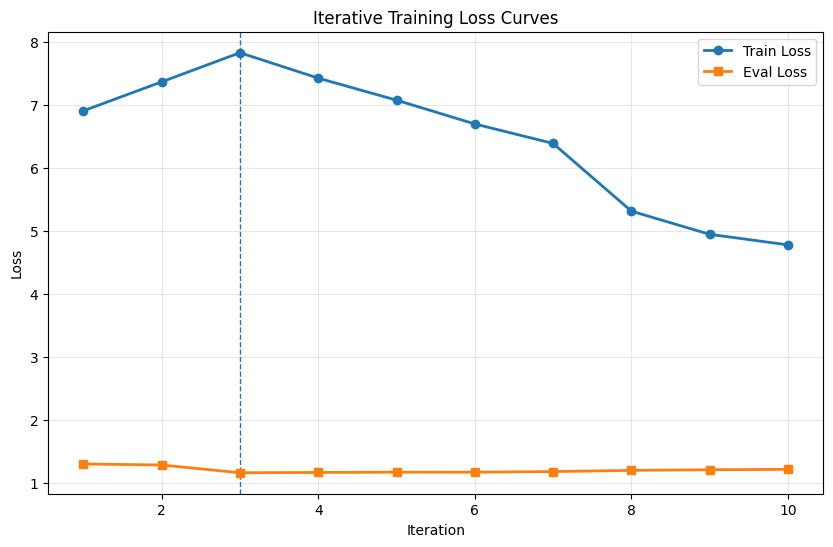

In [25]:
if iteration_metrics:
    iterations = [m.get("iteration") for m in iteration_metrics]
    train_losses = [m.get("train_loss") for m in iteration_metrics]
    eval_losses = [m.get("eval_loss") for m in iteration_metrics]

    def to_float_or_nan(x):
        try:
            x = float(x)
            return x if math.isfinite(x) else float("nan")
        except Exception:
            return float("nan")

    train_losses = [to_float_or_nan(x) for x in train_losses]
    eval_losses = [to_float_or_nan(x) for x in eval_losses]

    fig, ax = plt.subplots(figsize=(10, 6))

    if best_iteration is not None:
        ax.axvline(best_iteration, linestyle="--", linewidth=1)
    
    ax.plot(iterations, train_losses, marker="o", label="Train Loss", linewidth=2)
    ax.plot(iterations, eval_losses, marker="s", label="Eval Loss", linewidth=2)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Iterative Training Loss Curves")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()

## Load Best Adapter and Evaluate Prompts

In [26]:
print('Loading best adapter for evaluation...')
best_adapter_path = ADAPTER_DIR / 'best_adapter'

base_eval_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=dtype)
base_eval_model.to(device)

eval_model = PeftModel.from_pretrained(base_eval_model, str(best_adapter_path))
eval_model.eval()

print('Evaluating on generic prompts...')
generic_results = evaluate_model_on_prompts(
    model=eval_model,
    tokenizer=tokenizer,
    prompts=GENERIC_EVAL_PROMPTS,
    device=str(device),
    max_tokens=120
)
print_evaluation_summary(generic_results)

print('\nEvaluating on CDK prompts...')
cdk_results = evaluate_model_on_prompts(
    model=eval_model,
    tokenizer=tokenizer,
    prompts=CDK_EVAL_PROMPTS,
    device=str(device),
    max_tokens=160
)
print_evaluation_summary(cdk_results)

all_results = generic_results + cdk_results
valid_count = sum(1 for r in all_results if r['syntax_valid'])

Loading best adapter for evaluation...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating on generic prompts...
EVALUATION SUMMARY
Total samples: 3
Syntax valid: 3/3 (100.0%)

Latency:
  Mean: 4157.7ms
  P50:  4334.2ms
  P95:  6001.5ms

Keyword match rate: 91.7%

Detailed Results:
✓ Factorial Function: 6001ms, keywords: 5/5
✓ List Filter: 2137ms, keywords: 5/5
✓ String Reversal: 4334ms, keywords: 3/4

Evaluating on CDK prompts...
EVALUATION SUMMARY
Total samples: 2
Syntax valid: 0/2 (0.0%)

Latency:
  Mean: 5707.6ms
  P50:  5709.5ms
  P95:  5709.5ms

Keyword match rate: 90.0%

Detailed Results:
✗ S3 Bucket with Encryption: 5706ms, keywords: 4/5
✗ Lambda Function: 5709ms, keywords: 5/5


In [28]:
from textwrap import indent

for r in generic_results:
    print("=" * 90)
    print(f"TEST: {r.get('name')}")
    print(f"Latency: {r.get('latency_ms', 0):.0f} ms | Syntax valid: {r.get('syntax_valid')}"
          f" | Keyword match: {r.get('keyword_match_rate')}")
    print("-" * 90)
    print("PROMPT:\n" + indent(r.get("prompt", ""), "  "))
    print("-" * 90)
    print("GENERATED:\n" + indent(r.get("generated", ""), "  "))
    print()


TEST: Factorial Function
Latency: 6001 ms | Syntax valid: True | Keyword match: 1.0
------------------------------------------------------------------------------------------
PROMPT:
  # Write Python code for the following docstring
  """
  Calculate the factorial of a number using recursion.
  Args:
      n: A non-negative integer
  Returns:
      The factorial of n
  """

  # Code:

------------------------------------------------------------------------------------------
GENERATED:
  def factorial(n):
      """Calculate the factorial of a number using recursion.
      Args:
          n: A non-negative integer
      Returns:
          The factorial of n
      """
      if n == 0:
          return 1
      else:
          return n * factorial(n-1)  # Recursive case: n! = n * (n-1)!

TEST: List Filter
Latency: 2137 ms | Syntax valid: True | Keyword match: 1.0
------------------------------------------------------------------------------------------
PROMPT:
  # Write Python code for the 

In [30]:
for r in cdk_results:
    print("=" * 90)
    print(f"TEST: {r.get('name')}")
    print(f"Latency: {r.get('latency_ms', 0):.0f} ms | Syntax valid: {r.get('syntax_valid')}"
          f" | Keyword match: {r.get('keyword_match_rate')}")
    print("-" * 90)
    print("PROMPT:\n" + indent(r.get("prompt", ""), "  "))
    print("-" * 90)
    print("GENERATED:\n" + indent(r.get("generated", ""), "  "))
    print()

TEST: S3 Bucket with Encryption
Latency: 5706 ms | Syntax valid: False | Keyword match: 0.8
------------------------------------------------------------------------------------------
PROMPT:
  # Write Python code for the following docstring
  """
  Create an S3 bucket with:
  - Encryption enabled (KMS)
  - Versioning enabled
  - Block public access
  """

  # Code:

------------------------------------------------------------------------------------------
GENERATED:
  def create_bucket(bucket_name, kms_key_id):
      """Create an S3 bucket with:
      - Encryption enabled (KMS)
      - Versioning enabled
      - Block public access
      """
      s3 = boto3.client('s3')
      s3.create_bucket(
          Bucket=bucket_name,
          CreateBucketConfiguration={
              'LocationConstraint': region
          },
          ObjectLockEnabledForBucket=True,
          ObjectLockEnabled=True,
          ObjectLockDefaultRetention={
              'Mode': 'GOVERNANCE',
              'Statu

## Save Training Summary

In [31]:
results = {
    'model_name': MODEL_NAME,
    'training_type': 'iterative_subset_lora',
    'best_iteration': best_iteration,
    'best_eval_loss': best_eval_loss,
    'config': {
        'max_length': MAX_LENGTH,
        'seed': SEED,
        'num_iterations': NUM_ITERATIONS,
        'samples_per_iteration': SAMPLES_PER_ITERATION,
        'epochs_per_iteration': EPOCHS_PER_ITERATION,
        'val_max_samples': VAL_MAX_SAMPLES,
        'batch_size': BATCH_SIZE,
        'grad_accum': GRADIENT_ACCUMULATION_STEPS,
        'lr': LEARNING_RATE,
        'warmup_ratio': WARMUP_RATIO,
        'save_steps': SAVE_STEPS,
        'lora': {
            'r': LORA_R,
            'alpha': LORA_ALPHA,
            'dropout': LORA_DROPOUT,
            'target_modules': LORA_TARGET_MODULES,
        },
    },
    'iteration_metrics': iteration_metrics,
}

out_path = EVAL_DIR / 'training_summary_iterative.json'
out_path.parent.mkdir(parents=True, exist_ok=True)
with open(out_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2)

print(f"Saved training summary to: {out_path}")


Saved training summary to: /storage/homefs/ai22t082/code_complete/evaluation/training_summary_iterative.json


In [33]:
@dataclass
class EvaluationPrompt:
    """Standard evaluation prompt."""
    name: str
    prompt: str
    language: str = "python"
    expected_keywords: List[str] = None

GENERIC_EVAL_PROMPTS = [
    EvaluationPrompt(
        name="Factorial Function",
        prompt="""# Write Python code for the following docstring
\"\"\"
Calculate the factorial of a number using recursion.
Args:
    n: A non-negative integer
Returns:
    The factorial of n
\"\"\"

""",
        language="python",
    ),
    EvaluationPrompt(
        name="List Filter",
        prompt="""# Write Python code for the following docstring
\"\"\"
Filter a list to keep only even numbers.
Args:
    numbers: A list of integers
Returns:
    A list containing only even numbers
\"\"\"

""",
        language="python",
    ),
    EvaluationPrompt(
        name="String Reversal",
        prompt="""# Write Python code for the following docstring
\"\"\"
Reverse a string.
Args:
    text: The input string
Returns:
    The reversed string
\"\"\"

""",
        language="python",
    ),
]

In [34]:
evaluate_model_on_prompts(
    model=eval_model,
    tokenizer=tokenizer,
    prompts=GENERIC_EVAL_PROMPTS,
    device=str(device),
    max_tokens=120
)

[{'name': 'Factorial Function',
  'prompt': '# Write Python code for the following docstring\n"""\nCalculate the factorial of a number using recursion.\nArgs:\n    n: A non-negative integer\nReturns:\n    The factorial of n\n"""\n\n',
  'generated': 'def factorial(n):\n    """Calculate the factorial of a number using recursion.\n    Args:\n        n: A non-negative integer\n    Returns:\n        The factorial of n\n    """\n    if n == 0:\n        return 1\n    else:\n        return n * factorial(n-1)  # Recursive case: n! = n * (n-1)!',
  'latency_ms': 2746.1767196655273,
  'syntax_valid': True,
  'syntax_error': None,
  'keywords_found': [],
  'keywords_expected': [],
  'keyword_match_rate': 0},
 {'name': 'List Filter',
  'prompt': '# Write Python code for the following docstring\n"""\nFilter a list to keep only even numbers.\nArgs:\n    numbers: A list of integers\nReturns:\n    A list containing only even numbers\n"""\n\n',
  'generated': 'def filter_even(numbers):\n    """\n    Fi

In [ ]:
from src.evaluation import generate_code

# Benchmark with different prompt lengths
benchmark_prompts = [
    "def hello():",  # Short
    "def process_data(data):\n    # Process input\n    result = []",  # Medium
    """class DataProcessor:
    def __init__(self, config):
        self.config = config

    def process(self, data):
        # Complex processing logic
        for item in data:""",  # Long
]

print("Benchmarking inference latency...")
print("=" * 60)

latencies = []
num_runs = 5

for prompt in benchmark_prompts:
    for _ in range(num_runs):
        _, latency = generate_code(
            model=model,
            tokenizer=tokenizer,
            prompt=prompt,
            max_tokens=15,
            device=str(device)
        )
        latencies.append(latency)

# Calculate statistics
latencies_sorted = sorted(latencies)
p50 = latencies_sorted[len(latencies_sorted)//2]
p95 = latencies_sorted[int(len(latencies_sorted)*0.95)]

In [ ]:
from src.data_processing import tokenizer_supports_fim
from src.evaluation import summarize_evaluation_results

fim_supported = tokenizer_supports_fim(tokenizer)

# Prepare baseline results
baseline_results = {
    "model_name": MODEL_NAME,
    "model_type": "M0_baseline",
    "fim_supported": fim_supported,
    "generic_evaluation": {
        "summary": summarize_evaluation_results(generic_results),
        "detailed_results": generic_results
    },
    "cdk_evaluation": {
        "summary": summarize_evaluation_results(cdk_results),
        "detailed_results": cdk_results
    },
    "latency_benchmark": {
        "mean_ms": float(np.mean(latencies)),
        "median_ms": float(p50),
        "p95_ms": float(p95),
        "min_ms": float(min(latencies)),
        "max_ms": float(max(latencies)),
        "std_dev_ms": float(np.std(latencies)),
        "num_samples": len(latencies),
        "p50_requirement_met": p50 <= 300,
        "p95_requirement_met": p95 <= 800
    },
    "overall_metrics": {
        "total_evaluations": len(all_results),
        "syntax_valid_count": valid_count,
        "syntax_validity_percent": 100 * valid_count / len(all_results)
    }
}

# Save to JSON
results_file = EVAL_DIR / "baseline_m0_results.json"
with open(results_file, 'w') as f:
    json.dump(baseline_results, f, indent=2)